In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
df_mm400 = pd.read_excel("./data/MM400_HF2_5_5_5.xlsx")

In [14]:
df_nrwm = pd.read_excel("./data/NRWM_HF2_5_5_5.xlsx", sheet_name=1)

In [15]:
df_mm400.head()

,TIME,C
0,0.0,0.000
1,50.0,0.067
2,100.0,0.018
3,150.0,0.002
4,200.0,0.016


In [16]:
df_nrwm.head()

,TIME,C
0,5,-0.005033
1,10,-0.032356
2,15,-0.015387
3,20,0.009635
4,25,0.043717


In [17]:
# Set configuration constants
tTimeBase = 1e-6
thresholdHi = 0.9
thresholdLo = 0.1

In [18]:
# helpers
def sq(x): 
    return x*x


def plotResults(**kwargs):
    
### Plot results ###
    
#     df = dataFrame of TIME and CURRENT values
#     valueField: string -- name of dataFrame field with current values
#     timeField: string -- name of dataFrame field with time values
#     hiThresholdPoint: tuple (<time>, <value>) -- value of point where instantaneous current crosses the high threshold 
#     loThresholdPoint: tuple (<time>, <value>) -- value of point where instantaneous current crosses the low threshold
#     thresholds: tuple (<high threshold>, <low threshold>) -- threshold values in interval (0 , 1]
#     ylimits: tuple (ymin, ymax) -- vertical extents of plot

    df = kwargs["df"]
    valueField = kwargs["valueField"]
    timeField = kwargs["timeField"]
    ISO_RMS = kwargs["ISO_RMS"]
    hiThresholdPoint = kwargs["hiThresholdPoint"]
    loThresholdPoint = kwargs["loThresholdPoint"]
    thresholds = kwargs["thresholds"]
    yLimits = kwargs["yLimits"]

        
    xHi, yHi = (hiThresholdPoint[0], hiThresholdPoint[1])
    xLo, yLo = (loThresholdPoint[0], loThresholdPoint[1])
    
    xMin, xMax = 0, df[timeField].values[-1]*tTimeBase
    yMin, yMax = yLimits
    
    threshHi, threshLo = thresholds
    
    timeScale = 1/tTimeBase

    f, ax = plt.subplots(1,1,figsize=(15,10))
    
    # Plot critical points
    ax.plot(xHi,yHi,"bs",markersize=10, fillstyle='none')
    ax.plot(xLo,yLo,"gs",markersize=10, fillstyle='none')
    
    # Plot some convenience lines and text
    ax.hlines([ISO_RMS, threshHi*ISO_RMS, threshLo*ISO_RMS], 0, xMax, linestyles='dashed', colors=["blue", "red", "red"])
    ax.vlines(xHi, 0, yMax - 0.1, linestyles='dashed', colors='red')
    ax.vlines(xLo, 0, 0.6, linestyles='dashed', colors='red')
    
    legend = ["Qualifying point", "Qualifying point",
              f"ISO RMS", f"{thresholds[0]:.0%}",f"{thresholds[1]:.0%}"        ]
    ax.legend(legend,loc='best')
    
    # Plot instantaneous data
    ax.plot(df[timeField]*tTimeBase, df[valueField],"ro")
    ax.plot(df[timeField]*tTimeBase, df[valueField])
    
    title = f"RMS measurement time = {1000*xHi:.3} mSec\nCurrent flow time = {1000*xLo:.3} mSec\nISO RMS: {ISO_RMS:.5} kA"
    plt.title(title)
    
    ax.set_xlabel("Time (uSec)")
    ax.set_ylabel("Current (kA)")
    
    ax.grid()
    plt.savefig("figs/ISORMS.png",bbox_inches="tight")
    #plt.show()
   # ax.savefig("figs/ISORMS.png",bbox_inches="tight")

In [19]:
# main process
def calculateISO_RMS(df, valueField, timeField, threshHi, threshLo):
    
    meanSquare = 0
    index = 0
    
    # Capture and store the points where the instantaneous value crosses the high and low threshold of the RMS value
    #  computed up to that point.
    # Each point is described by a tuple: (dataPoint_time, dataPoint_value)
    candidateHi = (0, 0)
    candidateLo = (0, 0)
    ISO_meanSquare = 0
    dataPoint_last = df.loc[0,valueField]
    
    # Read in the data, compute RMS using "on-line" method, and test for candidacy 
    # Dataframe index is continguous integers starting at 0
    for i in df.index:
        if i > 0:
            dataPoint_last = df.loc[i-1,valueField]
            dataPoint_next = df.loc[i,valueField]
            timeNext = df.loc[i,timeField]*tTimeBase
        
            meanSquare = 1/i * ((i-1)*meanSquare + sq(dataPoint_next)) # on-line calculation

            # We do comparison tests with mean square values to avoid computation burden of doing a square-root each time.
            # We capture points that qualify as a high to low transition across the high threshold point.  
            # In the case of high ripple or other irregularities in the instantaneous current signal, the last point
            #  captured will represent the final transition point.
            if sq(dataPoint_last) > meanSquare * sq(threshHi) and sq(dataPoint_next) < meanSquare * sq(threshHi):
                candidateHi = (timeNext, dataPoint_next)
                ISO_meanSquare = meanSquare

            # For the high to low transistion acrosss the low threshold point, we compare to the last mean square 
            #  value detected by the last high to low transition across the high threshold point
            if sq(dataPoint_last)  > ISO_meanSquare * sq(threshLo) and sq(dataPoint_next) < ISO_meanSquare * sq(threshLo):
                candidateLo =  (timeNext, dataPoint_next)
        #print(candidateHi, candidateLo)
    ISO_RMS = np.sqrt(ISO_meanSquare)
    return ISO_RMS, candidateHi, candidateLo
                            

In [20]:
df = df_mm400
#df = df_nrwm

field_mm400 = "C"
field_nrwm = "C"

timeField_mm400 = 'TIME'
timeField_nrwm = 'TIME'

threshHi = 0.9
threshLo = 0.1

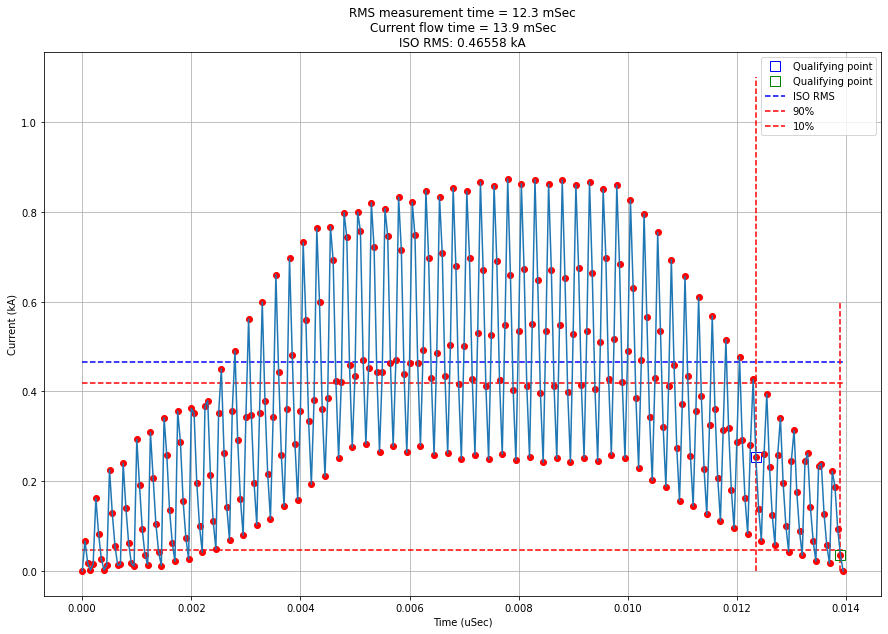

In [21]:
# def findEndOfWeldCandidates(df, field, threshHi, threshLo):
ISO_RMS, candidateHi, candidateLo = calculateISO_RMS(df, field_mm400,timeField_mm400, threshHi, threshLo)
# def  plotResults(df, valueField, timeField, hiThresholdPoint, loThresholdPoint, thresholds, ylimits):
plotResults(df=df, 
            valueField=field_mm400, 
            timeField=timeField_mm400, 
            ISO_RMS=ISO_RMS, 
            hiThresholdPoint=candidateHi, 
            loThresholdPoint=candidateLo, 
            thresholds=(0.9, 0.1), 
            yLimits=(0, 1.2))